<a href="https://colab.research.google.com/github/retro-3101/df_generation/blob/main/inter_face_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/shekhar-86/df_generation.git
%cd ./df_generation
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O ./stylegan_ffhq.pth --quiet

Cloning into 'df_generation'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 42 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), 71.79 KiB | 1.63 MiB/s, done.
/content/df_generation


In [ ]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image
from google.colab.patches import cv2_imshow
import torch
from model_settings import MODEL_POOL
from generator import StyleGANGenerator

In [ ]:
generator = StyleGANGenerator()
model_name = "stylegan_ffhq"
ATTRS = ['age', 'gender', 'pose', 'smile', 'eyeglasses']
latent_space_type = "W"
boundaries = {}
for i, attr_name in enumerate(ATTRS):
  boundary_name = f'{model_name}_{attr_name}'
  if  latent_space_type == 'W':
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')
  else:
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')

In [ ]:
def sample_vectors(generator, num, latent_space_type='Z', seed=0):
  np.random.seed(seed)
  vectors = generator.sample(num, latent_space_type)
  if latent_space_type == 'W':
    vectors = torch.from_numpy(vectors).type(torch.FloatTensor).to(generator.run_device)
    vectors = generator.get_value(generator.model.mapping(vectors))
  return vectors


def display_image(images, col, size=256):
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((size * row, size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * size
    x = j * size
    if height != size or width != size:
      image = cv2.resize(image, (size, size))
    fused_image[y:y + size, x:x + size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  cv2_imshow(cv2.cvtColor( fused_image, cv2.COLOR_RGB2BGR))

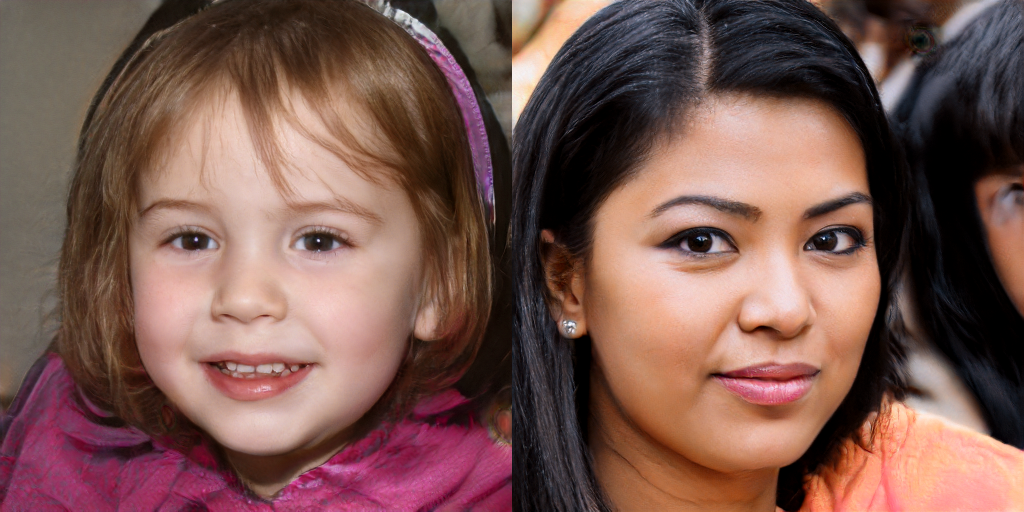

In [ ]:
from IPython.display import clear_output
#@title { display-mode: "form", run: "auto" }

num_samples = 2 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 664 #@param {type:"slider", min:0, max:1000, step:1}
latent_vectors = sample_vectors(generator, num_samples, latent_space_type, noise_seed)
if latent_space_type == 'W':
  kwargs = {'latent_space_type': 'W', 'generate_style' : True}
else:
  kwargs = {}
images = generator.synthesize(latent_vectors, **kwargs)['image']
clear_output()
display_image(images, num_samples, size = 512)

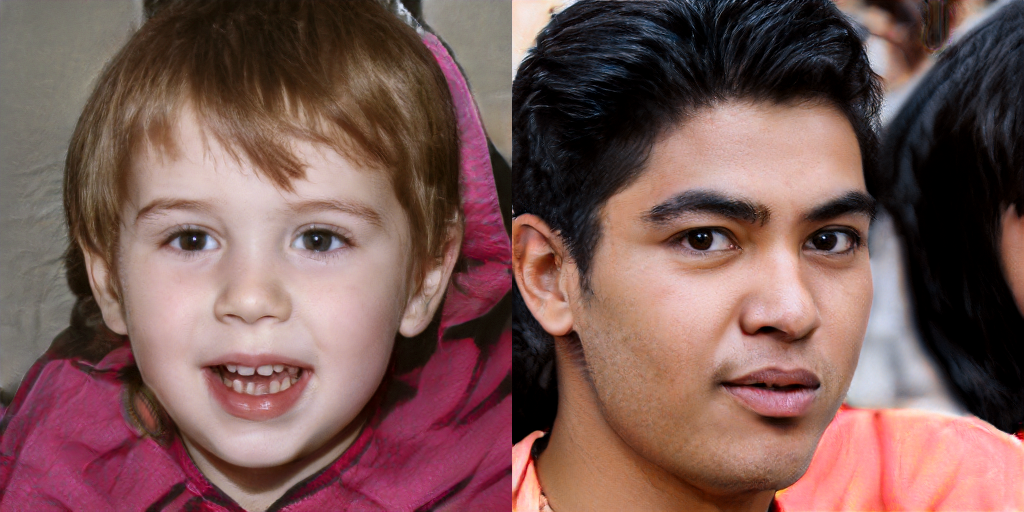

In [ ]:
#@title { display-mode: "form", run: "auto" }

age = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
gender = 2 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses= 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0.2 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = -0.6 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

new_vector = latent_vectors.copy()
for i, attr_name in enumerate(ATTRS):
  print(attr_name)
  new_vector += boundaries[attr_name] * eval(attr_name)

new_images = generator.synthesize(new_vector, **kwargs)['image']
clear_output()
display_image(new_images, num_samples, size = 512)